
# Modelflow extensions to pandas

Modeflow inherits all the capabilities of pandas and extends some as well. 

Data in a dataframe can be modified directly with built-in pandas functionalities like `.loc[]` and `eval()`, but `modelflow` extends these capabilities with in important ways with the `.upd()` and `.mfcalc()` methods. 


## .upd() method of modelflow


The ```.upd()``` method extends pandas by giving the user a concise and expressive way to modify data in a dataframe using a syntax that a database-manager or macroeconomic modeler might find more natural. 

Notably it allows the user to employ formula's to do updates, and supports both lags and leads on variables. 

```.upd()``` can be used to:

 - Perform different types of  updates
 - Perform multiple updates each on a new line 
 - Perform changes over specific periods 
 - Use one input which is used for all time frames, or a separate input for each time 
 - Preserve pre-shock growth rates for out of sample time-periods 
 - Display results 
 
### ```.upd()``` method operators 
Below are some of the operators that can be used in the ```.upd()``` method

**Types of update:** 

| Update to perform |Use this operator|
| :- | :---|
 Set a variable equal to the input| = 
 Add the input to the input | + 
 Set the variable to itself multiplied by the input | *
 Increase/Decrease the variable by a percent of itself (1+input/100) | %
 Set the growth rate of the variable to the input | =growth
 Change the growth rate of the variable to its current growth rate plus the input value in percentage points  | +growth 
 Specify the amount by which the variable should increase from its previous period level ($\Delta = var_t - var_{t-1}$)| =diff

:::{danger}

Note: the syntax of an update command requires that there be a space between variable names and the operators.

Thus ```df.upd("A = 7")``` is fine, but ```df.upd("A =7")``` will generate an error.

Similarly  ```df.upd("A * 1.1")``` is fine, but ```df.upd("A* 1.1")``` will generate an error.
:::

 

### ```.upd()``` some examples


### Setting up the python environment

In order to use ```.upd()``` all of the necessary libraries must be **imported** into the python session.

In [ ]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2

# First import pandas and the model into the  workspace
# There is no problem importing multiple times, though it is not very efficient.
import pandas as pd

from modelclass import model 
# functions that improve rendering of modelflow outputs under Jupyter Notebook
model.widescreen()
model.scroll_off()




Now create a dataframe using standard pandas syntax.  In this instance with years as the index and a dictionary defining the variables and their data.

In [3]:
# Create a dataframe using standard pandas

df = pd.DataFrame({'B': [1,1,1,1],'C':[1,2,3,6],'E':[4,4,4,4]},index=[2018,2019,2020,2021])
df 

,B,C,E
2018,1,1,4
2019,1,2,4
2020,1,3,4
2021,1,6,4


A somewhat more creative way to initialize the dataframe for dates would use a loop to specify the dates that get passed to the constructor as an argument.  

Below a dataframe df with two Series (A and B), is initialized with the values 100 for all data points.

The index is defined dynamically by a loop ```index=[2020+v for v in range(number_of_rows)]``` that runs for number_of_rows times (6 times in this example) setting v equal to 2020+0, 2020+1,...,202+5. The resulting list whose values are assigned to index is \[2020,2021,2022,2023,2024,2025\].

The big advantage of this method is that if the user wanted to have data created for the period 1990 to 2030, they would only have to change number_of_rows from 6 to 41 and 2020 in the loop to 1990.

The second example simplifies further by just specifying the begin and end point of the range.

In [4]:
#define the number of years for which the data is to be created.
number_of_rows = 6 

# call the dataframe constructor
df = pd.DataFrame(100,
       index=[2020+v for v in range(number_of_rows)], # create row index
       # equivalent to index=[2020,2021,2022,2023,2024,2025] 
       columns=['A','B'])                                 # create column name 
df

df1 = pd.DataFrame(200,
       index=[v for v in range(2020,2030)], # create row index
       # equivalent to index=[2020,2021,...,2030] 
       columns=['A1','B1'])                                 # create column name 
df1

,A1,B1
2020,200,200
2021,200,200
2022,200,200
2023,200,200
2024,200,200
2025,200,200
2026,200,200
2027,200,200
2028,200,200
2029,200,200


### Use .upd to create a new variable (= operator)

With standard pandas a user can add a column (series) to a dataframe simply by assigning a adding to a dataframe.  For example:

```df['NEW2']=[17,12,14,15]```

```.upd()``` provides this functionality as well.

In [5]:
df2=df.upd('c = 142') 
df2

,A,B,C
2020,100,100,142.0
2021,100,100,142.0
2022,100,100,142.0
2023,100,100,142.0
2024,100,100,142.0
2025,100,100,142.0


:::{note}
Note that the new variable name was entered as a lower case 'c' here.  Lowercase letters are not legal ```modelflow``` variable names.  The `.upd()` method knows is part of modelflow and knows this rule, so it automatically translates lowercase entries into upper case so that the statement works.
:::

### Multiple updates and specific time periods

The modelflow method ```.upd()``` takes a string as an argument.  That string can contain a single update command or can contain multiple commands.

Moreover by including a \<Begin End\> date clause in a given update command, the update will be restricted to the associated time period.

The below illustrates this, modifying two existing variables A, B over different time periods and creating a new variable.  

```{danger}
Note that the third line inherits the time period of the previous line.

Note also the submitted string can include comments as well (denoted with the standard python # indicator).
```



In [6]:
df.upd("""
# Same number of values as years
<2021 2024> A = 42 44 45 46    # 4 years
<2020     > B = 200            # 1 year 
c = 500                        # Same period as previous line
<-0 -1> D = 33                   # All years 
""")

,A,B,C,D
2020,100,200,500.0,33.0
2021,42,100,0.0,33.0
2022,44,100,0.0,33.0
2023,45,100,0.0,33.0
2024,46,100,0.0,33.0
2025,100,100,0.0,33.0


:::{margin}
**Time scope of .upd()**

Made this a margin just to see

The update command takes a variety of mathematical operators ```=, +, *, % =GROWTH, +GROWTH, =DIFF``` and applies them to data for the period set in the leading <>.

If the user wants to modify a series or group of series for only a specific point in time or a period of time, she can indicate the period in the command line.

 - If **one date** is specified the operation is applied to a single point in time
 - If **two dates**  are specifies the operation is applied over a period of time.

The selected time period will persist until re-set with a new time specification. Useful to avoid visual noise if several variables are going to be updated for the same time period. 

The time period can be rest to the full time-period by using the special \<-0 -1\> time period.  More generally:

 - Indicates the start of the dataframe use -0
 - Indicates the end of the dataframe use -1
 
If no time is provided the dataframe start and end period will be used.  
:::


### Setting specific datapoints to specific values 

This example, demonstrates the equals operator.  The ```=``` operator indicates that the variable a should be set equal to the indicated values following the ```=``` operator (42 44 45 46 in the first line, 200 in the second and 500 inthe third). The dates enclosed in <> indicate the period over which the change should be applied.  

Either: 
 - The number of data points provided must match the number of dates in the period, Or
 - Only one data point is provided, it is applied to all dates in the period. 

If only one period is to be modified then it can be followed by just one date.

Note that the final line inherited the time period set in the second line.

In [7]:
df.upd("""
# Same number of values as years
<2021 2024> A = 42 44 45 46    # 4 years
<2023     > B = 200            # 1 year 
c = 500
""")

,A,B,C
2020,100,100,0.0
2021,42,100,0.0
2022,44,100,0.0
2023,45,200,500.0
2024,46,100,0.0
2025,100,100,0.0


### Adding  the specified  values to all values in a range (the + operator)

NB: Here upd with the  + operator indicates that we are adding 42. 

In [8]:
df.upd('''
# Or one number to all years in between start and end 
<2022 2024> B  +  42    # one value broadcast to 3 years 
''')

,A,B
2020,100,100
2021,100,100
2022,100,142
2023,100,142
2024,100,142
2025,100,100


### Multiplying all values in a range by the specified values (the * operator)

In [9]:
df.upd('''
# Same number of values as years
<2021 2023> A *  42 44 55
''')

,A,B
2020,100,100
2021,4200,100
2022,4400,100
2023,5500,100
2024,100,100
2025,100,100


### Increasing all  values in a range by a  specified percent amount (the % operator)
In this example:
 - A is increased by 42 and 44% over the range 2021 through 2022.
 - B is increased by 10 percent in all years
 - C is a new variable, is created and set to 100 for the whole range
 - C is decreased by 12 percent over the range 2023 through 2025.

In [10]:
df.upd('''
<2021 2022 > A %  42 44   
<-0 -1> B % 10            # all rows 
C = 100                   # all rows persist 
<2023 2025> C % -12       # now only for 3 years 
''')

,A,B,C
2020,100,110.0,100.0
2021,142,110.0,100.0
2022,144,110.0,100.0
2023,100,110.0,88.0
2024,100,110.0,88.0
2025,100,110.0,88.0


###  Set the percent growth rate to specified values (=GROWTH)

In [11]:
res = df.upd('''
# Same number of values as years
<2021 2022> A =GROWTH  1 5  
<2020> c = 100 
<2021 2025> c =GROWTH 2 
''')
print(f'Dataframe:\n{res}\n\nGrowth:\n{res.pct_change()*100}\n') # Explained b

Dataframe:
           A    B           C
2020  100.00  100  100.000000
2021  101.00  100  102.000000
2022  106.05  100  104.040000
2023  100.00  100  106.120800
2024  100.00  100  108.243216
2025  100.00  100  110.408080

Growth:
             A    B    C
2020       NaN  NaN  NaN
2021  1.000000  0.0  2.0
2022  5.000000  0.0  2.0
2023 -5.704856  0.0  2.0
2024  0.000000  0.0  2.0
2025  0.000000  0.0  2.0



### Add or subtract from the existing percent growth rate (+GROWTH operator) 

The below example is a bit more complicated.

The first line sets the growth rate of A to 1% in all periods beginning in  2021

The second command adds 2 3 4 5 6 to the growth rates in each period after 2021, resulting in growth rates of 3,4,5,6,7.

In [12]:
res =df.upd('''
<2021 > A =GROWTH  1  # All selected years set to the same growth rate
a +growth   2  # Add to the existing growth rate these numbers  
''')
print(f'Dataframe:\n{res}\n\nGrowth:\n{res.pct_change()*100}\n')

Dataframe:
        A    B
2020  100  100
2021  103  100
2022  100  100
2023  100  100
2024  100  100
2025  100  100

Growth:
             A    B
2020       NaN  NaN
2021  3.000000  0.0
2022 -2.912621  0.0
2023  0.000000  0.0
2024  0.000000  0.0
2025  0.000000  0.0



###  Set the change in a variable to specific values (=diff operator) 

$\Delta = var_t - var_{t-1} = some number$

Here sets the value of A in 2021 to 2 more than the value of 2020, and the 2022 value as 4 more than the **revised** value of 2021.

The second line creates a new variable "UPBY2" to the data frame and sets it equal to 100 for all periods,

The third line adds 2 to the previous periods value UPBY2.



In [13]:
df.upd('''
< 2021 2022> A =diff  2 4   # Same number of values as years
<2020 > UpBy2 = 100 # sets rows equal to the same  number for all years in between start and end 
<2021 2025> UpBy2 =diff  2  

''')

,A,B,UPBY2
2020,100,100,100.0
2021,102,100,102.0
2022,106,100,104.0
2023,100,100,106.0
2024,100,100,108.0
2025,100,100,110.0


### Recall  that we have not overwritten df, so the df dataframe is unchanged.

In [14]:
df

,A,B
2020,100,100
2021,100,100
2022,100,100
2023,100,100
2024,100,100
2025,100,100


:::{note}

The method `.upd()` only operates on on variable.  A command like `.upd('A = B')` would not work. For these kind of functions, use `.mfcalc()` (see next section).
:::

### Keep growth rates after the update time -- the --kg option

In a long projection it can sometime be useful to be able to update variables for which new information is available, but for the subsequent periods keep the growth rate the same as before the update. In database management this is frequently done when two time-series with different levels are spliced together.

The -kg or --keep_growth option instructs modelview to calculate the growth rate of the existing pre-change series, and then use it to preserve the pre-change growth rates of the series for the periods that were **not** changed. 

This allows to update variables for which new information is available, but keep the growth rate the same as before the update in the period after the update time.


#### The default keep_growth behaviour

The ```upd()``` method has a parameter ```keep_growth```, which by default is equal to ```False```.

```keep_growth``` determines how data in  the time periods after those where an update is executed are treated.  

If ```keep_growth``` is ```False``` then data in the sub-period after a change is left unchanged.

if ```keep_growth``` is set to "```True```" then the system will preserve the pre-change growth rate of the affected variable in the time period *after the change*. 

:::{note}
At the line level:
* ```keep_growth=True``` can be expressed as --kg
* ```keep_growth=False``` can be expressed as --nkg
:::
Let's see this in a concrete example.  Consider the following ```dataframe``` df with two variables A and B, that each grow by 2% per period, with A initialized at a level of 100 and B at a level of 110 so that we can see each separately on a graph.



In [15]:
df = pd.DataFrame(100,
       index=[2020+v for v in range(number_of_rows)], # create row index
       # equivalent to index=[2020,2021,2022,2023,2024,2025] 
       columns=['A','B']) 

df=df.upd("""<2021 -1> A =growth 2
           <2020 -1>   B = 110
          <2021 -1>    B =growth 2
          """)
# Store these variables for later use in comparisons
df['A_ORIG']=df['A']
df['B_ORIG']=df['B']
df


,A,B,A_ORIG,B_ORIG
2020,100.000000,110.000000,100.000000,110.000000
2021,102.000000,112.200000,102.000000,112.200000
2022,104.040000,114.444000,104.040000,114.444000
2023,106.120800,116.732880,106.120800,116.732880
2024,108.243216,119.067538,108.243216,119.067538
2025,110.408080,121.448888,110.408080,121.448888


<AxesSubplot:>

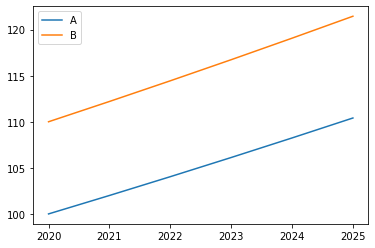

In [16]:
df[['A','B']].plot()

Now lets modify each by adding 5 to the level in 2022 and 2023.  For B we will do setting the keep_growth option as False and for 'B' keep_growth positive.  While the keep_growth is a global variable it can be set at the line level also using the --kg option (`keep_growth=True`) and --nkg option (`keep_growth=False`).


<AxesSubplot:>

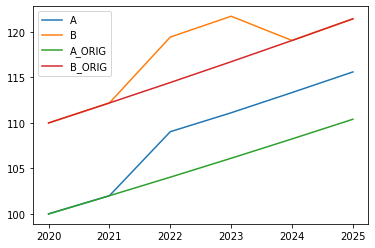

In [17]:
df=df.upd("""
            <2022 2023> A + 5 --kg
            <2022 2023> B + 5 --nkg
            """)

df[['A','B','A_ORIG','B_ORIG']].plot()
    

In the first example 'A' (the green and blue lines) the level of A is increased by 5 for two periods (2021-2022). The subsequent values are also increased and they were calculated to maintain the growth rate of the original series.

For the 'B' variable the same level change was input but because of the `--nkg` (equivalent to `keep_growth=False`) the periods after the change were unaffected and retained their old values.

Below are plots the growth rates of the two transformed series.

Here the growth in both series accelerates in 2022, by slightly less than 5 percentage points because a) the base of each is more than 100, with the base of B being higher (it was initialized at 110). In 2023 the growth rate of A returns to 2 percent, while the growth rate of B is actually negative because the level (see earlier graph) has fallen back to its original level.

<AxesSubplot:>

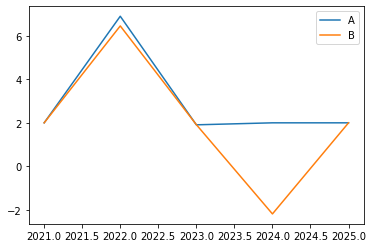

In [18]:
dfg=df[['A','B']].pct_change()*100
dfg.plot()

### .upd(,,,keep_growth) some more examples





###  Initialize a new dataframe First make a dataframe with some growth rate 

In [19]:

# instantiate a new dataframe with one column 'A' with avlue 100 everywhere and index 2020-2025
dftest = pd.DataFrame(100,
       index=[2020+v for v in range(number_of_rows)], # create row index
       # equivalent to index=[2020,2021,2022,2023,2024,2025] 
       columns=['A'])                                 # create column name 

# Update a to have growth rate accelerationg linearly by 1 from 1 oercent to 5 percent
original = dftest.upd('<2021 2025> a =growth 1 2 3 4 5')  
print(f'Levels:\n{original}\n\nGrowth:\n{original.pct_change()*100}\n')

Levels:
               A
2020  100.000000
2021  101.000000
2022  103.020000
2023  106.110600
2024  110.355024
2025  115.872775

Growth:
        A
2020  NaN
2021  1.0
2022  2.0
2023  3.0
2024  4.0
2025  5.0



### now update A in 2021 to 2023 to a new value

Below performs the same operation, the first time the updated value is assigned to the `dataframe` `nkg` and the default behaviour of ```keep_growth``` is ```False```

In the second example the ```-kg``` line option is specified, telling modelflow to maintain the growth rates of the dependent variable in the periods after the update is executed.

In [40]:
nokg = original.upd('''
<2021 2025>  a =growth 1 2 3 4 5 
<2021 2023>  a = 120  
''',lprint=0)

kg = original.upd('''
<2021 2025>  a =growth 1 2 3 4 5 
<2021 2023>  a = 120  --kg
''',lprint=0)


kg=kg.rename(columns={"A":"KG"})       #rename cols to facilitate display
nokg=nokg.rename(columns={"A":"NOKG"}) #rename cols to facilitate display

combo=pd.concat([kg,nokg], axis=1)
combo


print(f'Levels\n{combo}\n\nGrowth\n{combo.pct_change()*100}')

Levels
          KG        NOKG
2020  100.00  100.000000
2021  120.00  120.000000
2022  120.00  120.000000
2023  120.00  120.000000
2024  124.80  110.355024
2025  131.04  115.872775

growth
        KG      NOKG
2020   NaN       NaN
2021  20.0  20.00000
2022   0.0   0.00000
2023   0.0   0.00000
2024   4.0  -8.03748
2025   5.0   5.00000


:::{note} In the first example where KG (keep_growth) **was not set**, because the level was set constant for three periods at 120 the rate of growth was 0 for the final two years of the set period.  But following this update, the level of A in 2023 is 120. With ```keep_Growth=False``` (its default value)m the level of A in 2024 remains at its unchanged  unchanged (lower) level of 100.35. As a result, the growth rate in 2024 is negative.

In the **--kg** example, the pre-exsting growth rate (of 4%) is applied to the new value of 120 and so the level in 2024 is (120\*1.04)=124.8 and 2025 is 131.04.
:::


#### .upd() with the option keep_growth set globally

Above the line level option `--keep_growth` or `--kg` was used to keep the growth rate(or not) for a given operation.

This works because by default the option `Keep_growth` is set to false, implementing `--kg` at the line level temporarily set the keep_growth flag to  true for the specific line (and those following).

The `keep_growth` flag can also be set globally for all the lines by setting the option in the command line.

 ```keep_growth=True```.

Now as default, all lines will keep the growth rate (unless overridden at the line level with `--nkg` or `--no_keep_growth`.
 - c,d are updated in 2022 and 2023 and keep the growth rates afterwards
 - e the `--no_keep_growth` in this line prevents the updating 2024-2025

In [ ]:
# Create a data frame
dftest = pd.DataFrame(100,
       index=[2020+v for v in range(number_of_rows)], # create row index
       # equivalent to index=[2020,2021,2022,2023,2024,2025] 
       columns=['A','B','C','D','E'])                                 # create column name 
df

In [45]:
dfres = dftest.upd('''
<2022 2023> c = 200 
<2022 2023> d = 300  
<2022 2023> e = 400  --no_keep_growth 
''',keep_growth=True)  # <=  Set keep_growth to True for the entirety of the command, 
                       # except for e where it is overridden by the --no_keep_growth flag
print(f'Dataframe:\n{dfres}\n\nGrowth:\n{dfres.pct_change()*100}\n')

Dataframe:
        A    B      C      D    E
2020  100  100  100.0  100.0  100
2021  100  100  100.0  100.0  100
2022  100  100  200.0  300.0  400
2023  100  100  200.0  300.0  400
2024  100  100  200.0  300.0  100
2025  100  100  200.0  300.0  100

Growth:
        A    B      C      D      E
2020  NaN  NaN    NaN    NaN    NaN
2021  0.0  0.0    0.0    0.0    0.0
2022  0.0  0.0  100.0  200.0  300.0
2023  0.0  0.0    0.0    0.0    0.0
2024  0.0  0.0    0.0    0.0  -75.0
2025  0.0  0.0    0.0    0.0    0.0



### Update several variable in one line 
Sometime there is a need to update several variable with the same value over the same time frame. To ease this case .update can accept several variables in one line

In [24]:
df.upd('''
<2022 2024> h i j k =      40      # earlier values are set to zero by default
<2020>      p q r s =       1000   # All values beginning in 2020 set to 1000
<2021 -1>   p q r s =growth 2      # -1 indicates the last year of dataframe
''')

,A,B,H,I,J,K,P,Q,R,S
2020,100,100.0,0.0,0.0,0.0,0.0,1000.000000,1000.000000,1000.000000,1000.000000
2021,100,100.0,0.0,0.0,0.0,0.0,1020.000000,1020.000000,1020.000000,1020.000000
2022,100,100.0,40.0,40.0,40.0,40.0,1040.400000,1040.400000,1040.400000,1040.400000
2023,100,100.0,40.0,40.0,40.0,40.0,1061.208000,1061.208000,1061.208000,1061.208000
2024,100,100.0,40.0,40.0,40.0,40.0,1082.432160,1082.432160,1082.432160,1082.432160
2025,100,100.0,0.0,0.0,0.0,0.0,1104.080803,1104.080803,1104.080803,1104.080803


### .upd(,,scale=\<number, default=1>) Scale the updates 
When running a scenario it can be useful to be able to create a number of scenarios based on one update but with different scale. 

This can be particularly useful when we want to do sensitivity analyses of model results, depending on how heavily a shocked variable is hit

When using the scale option, scale=0  the baseline while scale=0.5 is a scenario half 
the severity.  

In the example below the values of the dataframes are printed. We use the scale option (setting to to 0, 0.5 and 1) to run three scenarios using the same code but where the update in each case is multiplied by either 0, 0.5 or 1.
:::{note}
Here we are just printing the outputs, a more interesting example would involve the solving a  model using different levels of a given shock. 
:::

In [25]:
print(f'input dataframe: \n{df}\n\n')
for severity in [0,0.5,1]: 
    # First make a dataframe with some growth rate 
    res = df.upd('''
    <2021 2025>
    a =growth 1 2 3 4 5 
    b + 10
    ''',scale=severity)
    print(f'{severity=}\nDataframe:\n{res}\n\nGrowth:\n{res.pct_change()*100}\n\n')
    #  
    # Here the updated dataframe is only printed. 
    # A more realistic use case is to simulate a model like this: 
    # dummy_ = mpak(res,keep='Severity {serverity}')    # more realistic 

input dataframe: 
        A      B
2020  100  100.0
2021  100  100.0
2022  100  100.0
2023  100  100.0
2024  100  100.0
2025  100  100.0


severity=0
Dataframe:
        A      B
2020  100  100.0
2021  100  100.0
2022  100  100.0
2023  100  100.0
2024  100  100.0
2025  100  100.0

Growth:
        A    B
2020  NaN  NaN
2021  0.0  0.0
2022  0.0  0.0
2023  0.0  0.0
2024  0.0  0.0
2025  0.0  0.0


severity=0.5
Dataframe:
               A      B
2020  100.000000  100.0
2021  100.500000  105.0
2022  101.505000  105.0
2023  103.027575  105.0
2024  105.088126  105.0
2025  107.715330  105.0

Growth:
        A    B
2020  NaN  NaN
2021  0.5  5.0
2022  1.0  0.0
2023  1.5  0.0
2024  2.0  0.0
2025  2.5  0.0


severity=1
Dataframe:
               A      B
2020  100.000000  100.0
2021  101.000000  110.0
2022  103.020000  110.0
2023  106.110600  110.0
2024  110.355024  110.0
2025  115.872775  110.0

Growth:
        A     B
2020  NaN   NaN
2021  1.0  10.0
2022  2.0   0.0
2023  3.0   0.0
2024  4.0   0.0
2

### .upd(,,lprint=True ) prints values the before and after update  

The ```lPrint``` option of the method ```upd()``` is by defualt ```= False```.  By setting it true an update command will output the results of the calculation comapriong the values of the dataframe (over the impacted period) before, after and the difference between the two.



In [26]:
df.upd('''
# Same number of values as years
<2021 2022> A *  42 44
''',lprint=1)

Update * [42.0, 44.0] 2021 2022
A                    Before                After                 Diff
2021               100.0000            4200.0000            4100.0000
2022               100.0000            4400.0000            4300.0000


,A,B
2020,100,100.0
2021,4200,100.0
2022,4400,100.0
2023,100,100.0
2024,100,100.0
2025,100,100.0


### .upd(,,create=True ) Requires the variable to exist  
Until now .upd has created variables if they did not exist in the input dataframe.

To catch misspellings the parameter ```create``` can be set to False. 
New variables will not be created, and an exception will be raised. 

Here Pythons exception handling is used, so the notebook will continue to run the cells below. 

In [27]:
try:
    xx = df.upd('''
    # Same number of values as years
    <2021 2022> Aa *  42 44
    ''',create=False)
    print(xx)
except Exception as inst:
    xx = None
    print(inst) 


Variable to update not found:AA, timespan = [2021 2022] 
Set create=True if you want the variable created: 
